In [1]:
test = "datathon-2025/test.csv"
train = "datathon-2025/train.csv"
sample_submission = "datathon-2025/sample_submission.csv"

In [2]:
import pandas as pd

df_train = pd.read_csv(train)
df_train

,event_time,event_type,product_id,category_id,user_id,user_session,session_value
0,2025-06-19 10:23:07+00:00,ADD_CART,PROD_011223,CAT_00054,USER_097562,SESSION_158779,90.29
1,2025-06-07 21:34:45+00:00,ADD_CART,PROD_005519,CAT_00144,USER_006535,SESSION_029987,16.39
2,2025-06-21 21:29:09+00:00,ADD_CART,PROD_000577,CAT_00273,USER_047199,SESSION_022134,64.27
3,2025-06-09 09:10:20+00:00,ADD_CART,PROD_019235,CAT_00442,USER_082028,SESSION_161308,41.67
4,2025-06-19 11:13:58+00:00,ADD_CART,PROD_001702,CAT_00025,USER_096574,SESSION_182859,86.11
...,...,...,...,...,...,...,...
141214,2025-06-20 13:39:03+00:00,BUY,PROD_014962,CAT_00019,USER_090115,SESSION_141762,177.32
141215,2025-06-13 11:59:24+00:00,BUY,PROD_002627,CAT_00030,USER_088499,SESSION_083133,35.73
141216,2025-06-07 09:21:08+00:00,BUY,PROD_002575,CAT_00030,USER_038679,SESSION_177107,73.35
141217,2025-06-16 20:15:38+00:00,BUY,PROD_000500,CAT_00062,USER_019663,SESSION_019029,378.94


In [ ]:
# // df_train['user_session'] = df_train['user_session'].str.split('_').str[1]


In [3]:
df_train['product_id'] = df_train['product_id'].str.split('_').str[1]
df_train['category_id'] = df_train['category_id'].str.split('_').str[1]
df_train['user_id'] = df_train['user_id'].str.split('_').str[1]

df_train['event_time'] = pd.to_datetime(df_train['event_time'])

event_type_map = {
    'ADD_CART': 0,
    'BUY': 1,
    'REMOVE_CART': 2,
    'VIEW': 3
}

df_train['event_type'] = df_train['event_type'].map(event_type_map)

In [4]:
# Add time of day column (0: morning, 1: afternoon, 2: evening, 3: night)
df_train['time_of_day'] = pd.cut(df_train['event_time'].dt.hour,
                                bins=[0, 6, 12, 18, 24],
                                labels=[3, 0, 1, 2],  # 3:night, 0:morning, 1:afternoon, 2:evening
                                right=False)

# Add weekday/weekend column
df_train['day_type'] = df_train['event_time'].dt.dayofweek.map(lambda x: 1 if x >= 5 else 0)  # 1: weekend, 0: weekday

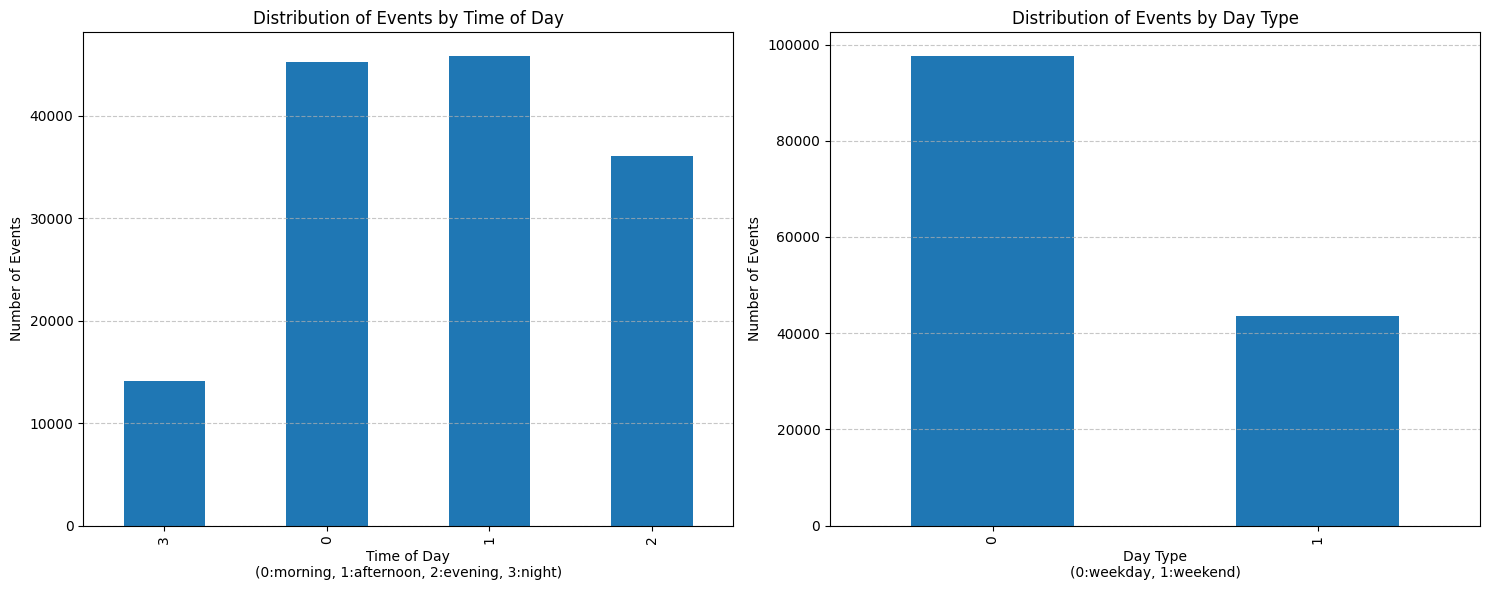

In [5]:
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# First subplot - Time of Day distribution
df_train['time_of_day'].value_counts().sort_index().plot(kind='bar', ax=ax1)
ax1.set_title('Distribution of Events by Time of Day')
ax1.set_xlabel('Time of Day\n(0:morning, 1:afternoon, 2:evening, 3:night)')
ax1.set_ylabel('Number of Events')
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Second subplot - Day Type distribution
df_train['day_type'].value_counts().sort_index().plot(kind='bar', ax=ax2)
ax2.set_title('Distribution of Events by Day Type')
ax2.set_xlabel('Day Type\n(0:weekday, 1:weekend)')
ax2.set_ylabel('Number of Events')
ax2.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [6]:
df_train = df_train.drop('event_time', axis=1)

In [7]:
df_train

,event_type,product_id,category_id,user_id,user_session,session_value,time_of_day,day_type
0,0,011223,00054,097562,SESSION_158779,90.29,0,0
1,0,005519,00144,006535,SESSION_029987,16.39,2,1
2,0,000577,00273,047199,SESSION_022134,64.27,2,1
3,0,019235,00442,082028,SESSION_161308,41.67,0,0
4,0,001702,00025,096574,SESSION_182859,86.11,0,0
...,...,...,...,...,...,...,...,...
141214,1,014962,00019,090115,SESSION_141762,177.32,1,0
141215,1,002627,00030,088499,SESSION_083133,35.73,0,0
141216,1,002575,00030,038679,SESSION_177107,73.35,0,1
141217,1,000500,00062,019663,SESSION_019029,378.94,2,0


In [8]:
# Drop the user_session column as it won't be used for training
X = df_train.drop(['user_session', 'session_value'], axis=1)
y = df_train['session_value']

# Display the first few rows of features (X) to verify the structure
print("Features shape:", X.shape)
print("\nFirst few rows of features:")
print(X.head())
print("\nTarget variable shape:", y.shape)
print("\nFirst few values of target:")
print(y.head())

Features shape: (141219, 6)

First few rows of features:
   event_type product_id category_id user_id time_of_day  day_type
0           0     011223       00054  097562           0         0
1           0     005519       00144  006535           2         1
2           0     000577       00273  047199           2         1
3           0     019235       00442  082028           0         0
4           0     001702       00025  096574           0         0

Target variable shape: (141219,)

First few values of target:
0    90.29
1    16.39
2    64.27
3    41.67
4    86.11
Name: session_value, dtype: float64


In [9]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Training set shape:', X_train.shape)
print('Testing set shape:', X_test.shape)

Training set shape: (112975, 6)
Testing set shape: (28244, 6)


In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141219 entries, 0 to 141218
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   event_type     141219 non-null  int64   
 1   product_id     141219 non-null  object  
 2   category_id    141219 non-null  object  
 3   user_id        141219 non-null  object  
 4   user_session   141219 non-null  object  
 5   session_value  141219 non-null  float64 
 6   time_of_day    141219 non-null  category
 7   day_type       141219 non-null  int64   
dtypes: category(1), float64(1), int64(2), object(4)
memory usage: 7.7+ MB


In [11]:
# Convert string IDs to integers
df_train['product_id'] = df_train['product_id'].astype(int)
df_train['category_id'] = df_train['category_id'].astype(int)
df_train['user_id'] = df_train['user_id'].astype(int)

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Convert categorical variables to numeric using one-hot encoding
# No need to specify columns that are already numeric
X_train_encoded = pd.get_dummies(X_train)
X_test_encoded = pd.get_dummies(X_test)

# Align the columns of train and test sets
common_columns = X_train_encoded.columns.intersection(X_test_encoded.columns)
X_train_encoded = X_train_encoded[common_columns]
X_test_encoded = X_test_encoded[common_columns]

xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    n_jobs=-1,
    tree_method='gpu_hist'  # Use GPU acceleration if available
)
xgb_model.fit(X_train_encoded, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test_encoded)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'Root Mean Squared Error: {rmse:.2f}')
print(f'R-squared Score: {r2:.2f}')

KeyboardInterrupt: 

In [13]:
# Read the test data
df_test = pd.read_csv(test)


# Split the ID columns to get the numeric part
df_test['product_id'] = df_test['product_id'].str.split('_').str[1]
df_test['category_id'] = df_test['category_id'].str.split('_').str[1]
df_test['user_id'] = df_test['user_id'].str.split('_').str[1]

# Convert string IDs to integers
df_test['product_id'] = df_test['product_id'].astype(int)
df_test['category_id'] = df_test['category_id'].astype(int)
df_test['user_id'] = df_test['user_id'].astype(int)


# Convert event_time to datetime
df_test['event_time'] = pd.to_datetime(df_test['event_time'])

event_type_map = {
    'ADD_CART': 0,
    'BUY': 1,
    'REMOVE_CART': 2,
    'VIEW': 3
}
# Map event types using the same mapping
df_test['event_type'] = df_test['event_type'].map(event_type_map)

# Add time of day column (0: morning, 1: afternoon, 2: evening, 3: night)
df_test['time_of_day'] = pd.cut(df_test['event_time'].dt.hour,
                               bins=[0, 6, 12, 18, 24],
                               labels=[3, 0, 1, 2],  # 3:night, 0:morning, 1:afternoon, 2:evening
                               right=False)

# Add weekday/weekend column
df_test['day_type'] = df_test['event_time'].dt.dayofweek.map(lambda x: 1 if x >= 5 else 0)  # 1: weekend, 0: weekday

# Drop the event_time column as it's no longer needed
df_test = df_test.drop('event_time', axis=1)

In [ ]:
# Prepare the test data with the same preprocessing as training data
# Drop the user_session column
X_test = df_test.drop(['user_session'], axis=1)

# Convert test data to one-hot encoding
X_test_encoded = pd.get_dummies(X_test)

# Align test data columns with training data columns
X_test_encoded = X_test_encoded.reindex(columns=common_columns, fill_value=False)

# Make predictions
predictions = xgb_model.predict(X_test_encoded)

# Create submission dataframe
submission = pd.DataFrame({
    'user_session': df_test['user_session'],
    'session_value': predictions
})

# Save predictions to CSV
submission.to_csv('submission.csv', index=False)

print("Predictions have been saved to 'submission.csv'")

In [11]:
# Create a copy of the processed training data
processed_train = df_train.copy()

# Ensure all numeric columns are in the right format
numeric_columns = ['event_type', 'product_id', 'category_id', 'user_id', 'session_value', 'time_of_day', 'day_type']
for col in numeric_columns:
    if col in processed_train.columns:
        if col == 'session_value':
            processed_train[col] = processed_train[col].astype(float)
        elif col == 'time_of_day':
            processed_train[col] = processed_train[col].astype('category')
        else:
            processed_train[col] = processed_train[col].astype(int)

# Save the processed training data
processed_train.to_csv('datathon-2025/processed_train.csv', index=False)
print("Processed training data has been saved to 'datathon-2025/processed_train.csv'")

Processed training data has been saved to 'datathon-2025/processed_train.csv'


In [14]:
# Create a copy of the processed test data
processed_test = df_test.copy()

# Ensure all numeric columns are in the right format
numeric_columns = ['event_type', 'product_id', 'category_id', 'user_id', 'time_of_day', 'day_type']
for col in numeric_columns:
    if col in processed_test.columns:
        if col == 'time_of_day':
            processed_test[col] = processed_test[col].astype('category')
        else:
            processed_test[col] = processed_test[col].astype(int)

# Save the processed test data
processed_test.to_csv('datathon-2025/processed_test.csv', index=False)
print("Processed test data has been saved to 'datathon-2025/processed_test.csv'")

Processed test data has been saved to 'datathon-2025/processed_test.csv'


In [21]:
import pandas as pd

# submission.csv dosyasını okuyun
df = pd.read_csv('submission.csv')

# 'user_session' sütununa göre gruplandırın ve 'Random Forest' sütununu toplayın
session_total_value = df.groupby('user_session')['Random Forest'].mean().reset_index()

# Sütun isimlerini daha anlamlı olacak şekilde değiştirin
session_total_value.columns = ['user_session', 'session_value']

# Sonuçları gösterin
print(session_total_value.head())

     user_session  session_value
0  SESSION_000000       85.76275
1  SESSION_000013       24.20750
2  SESSION_000022      204.36300
3  SESSION_000024       48.61730
4  SESSION_000025       48.73520


In [22]:
session_total_value.to_csv('submission.csv', index=False)
